In [ ]:
%pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 56.8 MB/s eta 0:00:00


In [ ]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import csv
import dlib
from torchvision.transforms.functional import to_pil_image
import mediapipe as mp

In [ ]:
# dataset path
environment = ''
def colab_or_not():
  if 'google.colab' in sys.modules:
    global environment
    from google.colab import drive
    print('Running in Google Colab')
    # Colab-specific code here
    !echo "Colab specific command"
    drive.mount('/content/drive')
    environment = 'colab'
    print(os.getcwd())
  else:
    print('Not running in Google Colab')
    # Non-Colab code here
    environment = 'local'
    print(os.getcwd())

colab_or_not()
print(environment)

Running in Google Colab
Colab specific command
Mounted at /content/drive
/content
colab


# Preprocessing

In [ ]:
# Load Mediapipe Face Mesh
import mediapipe as mp
import cv2
import numpy as np
import matplotlib.pyplot as plt

mp_face_mesh = mp.solutions.face_mesh

def get_landmark_locations(image):
    """
    Detects facial landmarks in the input image using Mediapipe and returns their locations.

    Parameters:
        image (numpy.ndarray): Input image (RGB format).

    Returns:
        numpy.ndarray: Array of landmark coordinates (x, y) or None if no face is detected.
    """
    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True) as face_mesh:
        # Process the image
        results = face_mesh.process(image)

        if not results.multi_face_landmarks:
            print("No faces detected in the image.")
            return None

        # Extract landmarks for the first detected face
        landmarks = results.multi_face_landmarks[0]
        landmark_coords = np.array([
            (int(landmark.x * image.shape[1]), int(landmark.y * image.shape[0]))
            for landmark in landmarks.landmark
        ])

        return landmark_coords

def plot_image_with_landmarks(image, landmarks):
    """
    Plots the original image with the facial landmarks overlaid.

    Parameters:
        image (numpy.ndarray): The original image (H, W, C) in RGB format.
        landmarks (numpy.ndarray): Array of facial landmark coordinates of shape (N, 2).

    Returns:
        None
    """
    if image.shape[-1] == 3:
        img_to_plot = image.copy()
    else:
        raise ValueError("The input image must be in RGB format.")

    # Create the plot
    plt.figure(figsize=(8, 8))

    # Plot the image
    plt.imshow(img_to_plot)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], c='red', s=10, label="Landmarks")

    # Add labels and grid
    plt.title("Image with Landmarks")
    plt.axis("off")
    plt.legend()

    plt.show()

def align_face_and_landmarks(image, landmarks, reference_landmarks, output_size=(256, 256)):
    """
    Aligns a face in the image based on landmarks and scales both the image and landmarks.

    Parameters:
        image (numpy.ndarray): Input image in RGB format (H, W, C).
        landmarks (numpy.ndarray): Detected landmarks of the face, shape (N, 2).
        reference_landmarks (numpy.ndarray): Reference landmarks for alignment, shape (M, 2).
        output_size (tuple): Desired output size for the aligned image (H, W).

    Returns:
        aligned_image (numpy.ndarray): Aligned and scaled face image (H, W, C).
        transformed_landmarks (numpy.ndarray): Transformed landmarks corresponding to the aligned image, shape (N, 2).
    """
    # Ensure input landmarks and reference landmarks are numpy arrays
    landmarks = np.array(landmarks, dtype=np.float32)
    reference_landmarks = np.array(reference_landmarks, dtype=np.float32)

    # Estimate affine transformation matrix using selected key landmarks
    transformation_matrix, _ = cv2.estimateAffinePartial2D(landmarks[:len(reference_landmarks)], reference_landmarks)

    # Apply the transformation to the image
    aligned_image = cv2.warpAffine(
        image,
        transformation_matrix,
        output_size,
        flags=cv2.INTER_LINEAR
    )

    # Transform all landmarks
    ones = np.ones((landmarks.shape[0], 1))  # Add ones for affine transformation
    landmarks_homogeneous = np.hstack([landmarks, ones])  # Convert to homogeneous coordinates

    transformed_landmarks = (transformation_matrix @ landmarks_homogeneous.T).T

    return aligned_image, transformed_landmarks

def generate_face_mask_from_mediapipe(image, landmarks, output_size=(256, 256)):
    """
    Generates a binary mask (1 for the face region, 0 elsewhere) based on Mediapipe facial landmarks.

    Parameters:
        image (numpy.ndarray): The input image (H, W, C) in RGB format.
        landmarks (numpy.ndarray): Mediapipe landmarks (468 x 2 array).
        output_size (tuple): Desired output size for the mask (H, W).

    Returns:
        numpy.ndarray: A binary mask of shape (H, W) with 1s in the face region.
    """
    # Define indices for the outer face boundary (chin and jawline points from Mediapipe)
    outer_face_indices = [
        10, 338, 297, 332, 284, 251, 389, 356, 454, 323, 361, 288, 397, 365, 379, 378,
        400, 377, 152, 148, 176, 149, 150, 136, 172, 58, 132, 93, 234, 127, 162, 21,
        54, 103, 67, 109, 10  # Ensure a closed loop
    ]

    # Get the points corresponding to the outer face
    outer_face_points = np.array([landmarks[i] for i in outer_face_indices], dtype=np.int32)

    # Create an empty mask
    mask = np.zeros(image.shape[:2], dtype=np.uint8)

    # Fill the polygon defined by the outer face points with 1
    cv2.fillPoly(mask, [outer_face_points], 1)

    # Resize the mask to the desired output size
    mask = cv2.resize(mask, output_size, interpolation=cv2.INTER_NEAREST)

    return mask

def align_source_to_target(source_image, source_landmarks, target_landmarks):
    """
    Aligns the source image to the target landmarks.

    Parameters:
        source_image (numpy.ndarray): The source image in RGB format.
        source_landmarks (numpy.ndarray): Landmarks for the source image.
        target_landmarks (numpy.ndarray): Landmarks for the target image.

    Returns:
        numpy.ndarray: Aligned source image.
        numpy.ndarray: Transformed landmarks of the source image.
    """
    output_size = (256, 256)  # Ensure the aligned image matches training input size
    aligned_source, transformed_landmarks = align_face_and_landmarks(
        source_image, source_landmarks, target_landmarks, output_size=output_size
    )
    return aligned_source, transformed_landmarks

def merge_images_with_mask(target_image, transformed_image, mask, center=None):
    """
    Merges the target and transformed images using CV2's seamlessClone function.

    Parameters:
        target_image (numpy.ndarray): The target image in RGB format.
        transformed_image (numpy.ndarray): The transformed source image in RGB format.
        mask (numpy.ndarray): Binary mask indicating the face region (1 for face, 0 elsewhere).
        center (tuple): Center of the mask on the target image (x, y). If None, center of the image is used.

    Returns:
        numpy.ndarray: Blended image using seamless cloning.
    """
    # Ensure mask is in uint8 format
    mask = (mask * 255).astype(np.uint8)

    # Determine the center of the mask if not provided
    if center is None:
        center = (target_image.shape[1] // 2, target_image.shape[0] // 2)

    # Apply seamless cloning
    blended_image = cv2.seamlessClone(
        src=transformed_image,      # Source image (transformed face)
        dst=target_image,           # Destination image (target face)
        mask=mask,                  # Binary mask
        p=center,                   # Center of the source image
        flags=cv2.NORMAL_CLONE      # Seamless blending type
    )

    return blended_image

In [ ]:
# scaling

def generate_image_scales(image_path):
    """
    Generates scaled versions of an input image.

    Parameters:
        image_path (str): Path to the input image.

    Returns:
        list: A list containing scaled images [8x8, 16x16, 32x32, 64x64, 128x128, 256x256].
    """
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Failed to load image. Please check the path.")

    # Ensure the image is 256x256
    image = cv2.resize(image, (256, 256))

    # Generate scales
    scales = [8, 16, 32, 64, 128, 256]
    scaled_images = [cv2.resize(image, (s, s)) for s in scales]

    return scaled_images

Scale 8x8:


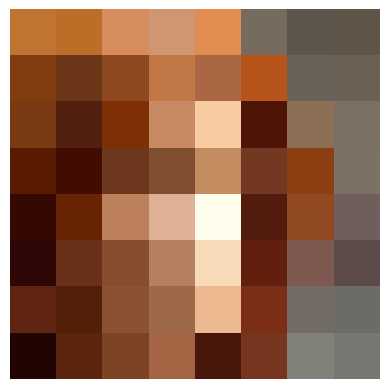

Scale 16x16:


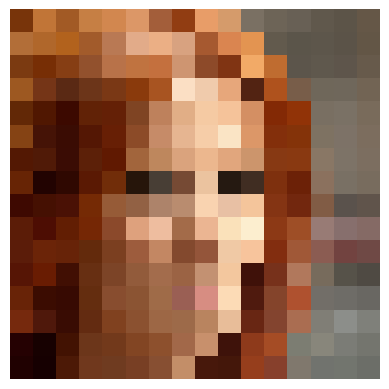

Scale 32x32:


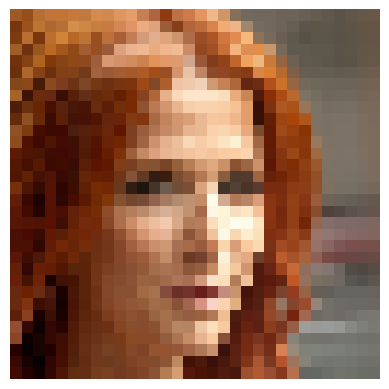

Scale 64x64:


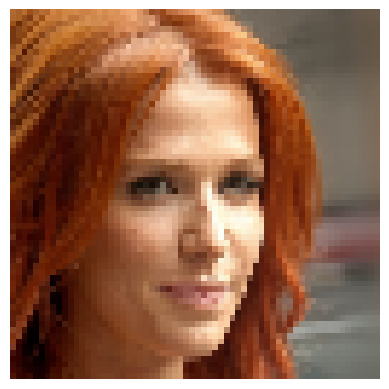

Scale 128x128:


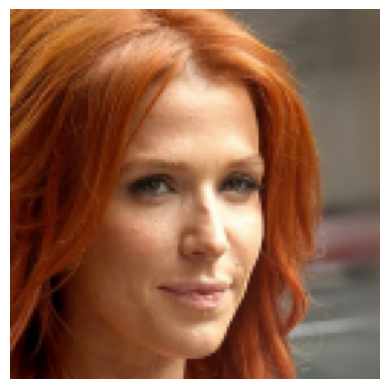

Scale 256x256:


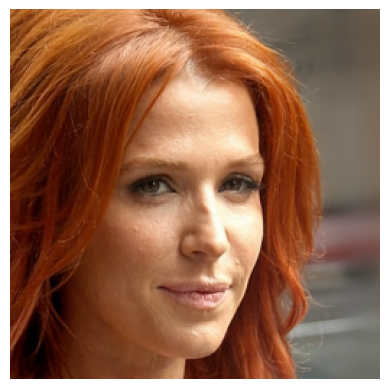

In [ ]:
# test scaling
scaled_images = generate_image_scales("/content/drive/My Drive/aml/celebAhq256small/img_2.png")
for i, scaled in enumerate(scaled_images):
     print(f"Scale {2**(i+3)}x{2**(i+3)}:")
     plt.imshow(cv2.cvtColor(scaled, cv2.COLOR_BGR2RGB))
     plt.axis('off')
     plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils, models
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(channels),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(channels),
            nn.Conv2d(channels, channels, kernel_size=1, stride=1, padding=0)
        )

    def forward(self, x):
        # Add the skip connection
        return x + self.conv_block(x)
    # no padding
    '''def forward(self, x):
        # Crop the input to match the reduced dimensions
        cropped_input = x[:, :, 2:-2, 2:-2]
        return cropped_input + self.conv_block(x)'''


In [ ]:
class MultiScaleCombiner(nn.Module):
    """
    Combines multiscale branches via nearest-neighbor upsampling and concatenation.
    """
    def __init__(self):
        super(MultiScaleCombiner, self).__init__()

    def forward(self, branches):
        """
        Forward pass for combining branches.

        Parameters:
            branches (list of torch.Tensor): A list of tensors from different branches
                                              (e.g., [8x8, 16x16, 32x32, ...]).

        Returns:
            torch.Tensor: The combined tensor after upsampling and concatenation.
        """
        # Upsample all branches to match the resolution of the largest branch
        max_size = branches[-1].shape[2:]  # Spatial size of the largest branch (H, W)
        upsampled_branches = [
            F.interpolate(branch, size=max_size, mode='nearest') for branch in branches
        ]

        # Concatenate along the channel axis
        combined = torch.cat(upsampled_branches, dim=1)  # Concatenate channels

        return combined

In [ ]:
class MultiScaleTransformationNetwork(nn.Module):
    """
    Multiscale transformation network as described in the paper.
    """
    def __init__(self, num_residual_blocks=2):
        super(MultiScaleTransformationNetwork, self).__init__()

        # Define branches for each scale
        self.branch_8x8 = self._make_branch(3, 32, num_residual_blocks)  # 3 input channels (RGB)
        self.branch_16x16 = self._make_branch(3, 32, num_residual_blocks)
        self.branch_32x32 = self._make_branch(3, 32, num_residual_blocks)
        self.branch_64x64 = self._make_branch(3, 32, num_residual_blocks)
        self.branch_128x128 = self._make_branch(3, 32, num_residual_blocks)
        self.branch_256x256 = self._make_branch(3, 32, num_residual_blocks)

        # Multiscale combiner
        self.combiner = MultiScaleCombiner()

        # Final output layer
        self.final_conv = nn.Conv2d(192, 3, kernel_size=1, stride=1, padding=0)

    def _make_branch(self, in_channels, out_channels, num_blocks):
        """
        Creates a branch with an initial convolution and a sequence of residual blocks.

        Parameters:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels for the initial convolution.
            num_blocks (int): Number of residual blocks in the branch.

        Returns:
            nn.Sequential: A branch with an initial convolution and residual blocks.
        """
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),  # Initial conv
            nn.ReLU(inplace=True)
        ]
        layers += [ResidualBlock(out_channels) for _ in range(num_blocks)]  # Residual blocks
        return nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass for the multiscale transformation network.

        Parameters:
            x (torch.Tensor): Input tensor of shape (B, C, H, W).

        Returns:
            torch.Tensor: Transformed tensor of shape (B, 3, H, W).
        """
        # Downsample input to each scale
        branch_inputs = [
            F.interpolate(x, size=(8, 8), mode='nearest'),
            F.interpolate(x, size=(16, 16), mode='nearest'),
            F.interpolate(x, size=(32, 32), mode='nearest'),
            F.interpolate(x, size=(64, 64), mode='nearest'),
            F.interpolate(x, size=(128, 128), mode='nearest'),
            F.interpolate(x, size=(256, 256), mode='nearest')
        ]

        # Process each scale through its branch
        branch_outputs = [
            self.branch_8x8(branch_inputs[0]),
            self.branch_16x16(branch_inputs[1]),
            self.branch_32x32(branch_inputs[2]),
            self.branch_64x64(branch_inputs[3]),
            self.branch_128x128(branch_inputs[4]),
            self.branch_256x256(branch_inputs[5])
        ]

        # Combine all branches
        combined_features = self.combiner(branch_outputs)

        # Final convolution to produce RGB output
        output = self.final_conv(combined_features)

        return output


In [ ]:
# Create the network
net = MultiScaleTransformationNetwork()

# Example input image (batch size 1, 3 channels, 256x256)
input_tensor = torch.randn(1, 3, 256, 256)

# Forward pass
output_tensor = net(input_tensor)

print("Output shape:", output_tensor.shape)  # Should be (1, 3, 256, 256)


Output shape: torch.Size([1, 3, 256, 256])


# Loss

In [ ]:
# Loss functions

# Define the VGG model for perceptual loss
class VGGFeatures(nn.Module):
    def __init__(self, layer_ids=[4, 9, 16, 23]):
        """
        Extracts features from a pre-trained VGG network.

        Parameters:
            layer_ids (list): Indices of layers to extract features from.
        """
        super(VGGFeatures, self).__init__()
        vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features
        self.layer_ids = layer_ids
        self.model = vgg[:max(layer_ids) + 1]  # Keep layers up to the maximum requested layer

        # Freeze VGG weights
        for param in self.model.parameters():
            param.requires_grad = False

    def forward(self, x):
        features = []
        for i, layer in enumerate(self.model):
            x = layer(x)  # Pass through each layer
            if i in self.layer_ids:  # Collect features at the specified layers
                features.append(x)
        return features

def content_loss(target_features, transformed_features):
    """
    Computes the content loss between target and transformed features.

    Parameters:
        target_features (list): List of feature maps from target image.
        transformed_features (list): List of feature maps from transformed image.

    Returns:
        torch.Tensor: Content loss.
    """
    loss = 0.0
    for src_feat, trans_feat in zip(target_features, transformed_features):
        loss += F.mse_loss(trans_feat, src_feat)  # No additional normalization needed
    return loss

def gram_matrix(features):
    """
    Computes the Gram matrix of the input features.

    Parameters:
        features (torch.Tensor): Feature map of shape (B, C, H, W).

    Returns:
        torch.Tensor: Gram matrix of shape (B, C, C).
    """
    B, C, H, W = features.size()
    features = features.view(B, C, H * W)  # Flatten the spatial dimensions
    gram = torch.bmm(features, features.transpose(1, 2))  # Compute Gram matrix
    gram = gram / (C * H * W)  # Normalize by the size of the feature map
    return gram

def gram_based_style_loss(source_features, transformed_features):
    """
    Computes the Gram-based style loss between source and transformed features.

    Parameters:
        source_features (list): List of feature maps from source image.
        transformed_features (list): List of feature maps from transformed image.

    Returns:
        torch.Tensor: Style loss.
    """
    loss = 0.0
    for source_feat, trans_feat in zip(source_features, transformed_features):
        source_gram = gram_matrix(source_feat)
        trans_gram = gram_matrix(trans_feat)
        loss += F.mse_loss(trans_gram, source_gram)
    return loss

def compute_luminance(image):
    """
    Computes the grayscale (luminance) version of an image.

    Parameters:
        image (torch.Tensor): Input image of shape (B, C, H, W).

    Returns:
        torch.Tensor: Grayscale image of shape (B, 1, H, W).
    """
    if image.shape[1] == 3:  # If RGB, convert to grayscale
        luminance = 0.299 * image[:, 0, :, :] + 0.587 * image[:, 1, :, :] + 0.114 * image[:, 2, :, :]
        luminance = luminance.unsqueeze(1)  # Add channel dimension
    else:
        luminance = image  # Already grayscale
    return luminance

def luminance_consistency_loss(generated_image, target_image, patch_size):
    """
    Computes the luminance consistency loss between the generated and target images.

    Parameters:
        generated_image (torch.Tensor): Generated image of shape (B, C, H, W).
        target_image (torch.Tensor): Target image of shape (B, C, H, W).
        patch_size (int): Size of the patches for luminance calculation.

    Returns:
        torch.Tensor: Luminance consistency loss.
    """
    # Convert to grayscale
    gen_luminance = compute_luminance(generated_image)
    target_luminance = compute_luminance(target_image)

    # Extract patches
    B, _, H, W = gen_luminance.shape
    gen_patches = gen_luminance.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    target_patches = target_luminance.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)

    # Compute average luminance for each patch
    gen_avg = gen_patches.mean(dim=(-1, -2))  # Average over height and width of patches
    target_avg = target_patches.mean(dim=(-1, -2))

    # Compute MSE loss between corresponding patches
    loss = torch.mean((gen_avg - target_avg) ** 2)
    return loss


def total_variation_loss(image):
    """
    Computes the total variation loss to encourage smoothness in the image.

    Parameters:
        image (torch.Tensor): Input image of shape (B, C, H, W).

    Returns:
        torch.Tensor: Scaled total variation loss.
    """
    # Horizontal differences
    loss_h = torch.sum((image[:, :, :, :-1] - image[:, :, :, 1:]) ** 2)
    # Vertical differences
    loss_v = torch.sum((image[:, :, :-1, :] - image[:, :, 1:, :]) ** 2)

    # Calculate the number of pixels in the image (B, C, H, W)
    num_pixels = image.numel()  # Total number of elements in the image

    # Scale the total variation loss
    return (loss_h + loss_v) / num_pixels


In [ ]:
# Initialize the feature extractor
vgg_extractor = VGGFeatures(layer_ids=[4, 9, 16, 23])  # Specify layers for feature extraction

# Example inputs (ensure they are resized to match VGG input requirements)
source_image = torch.randn(1, 3, 256, 256)
target_image = torch.randn(1, 3, 256, 256)
transformed_image = torch.randn(1, 3, 256, 256)

# Extract features
source_features = vgg_extractor(source_image)
target_features = vgg_extractor(target_image)
transformed_features = vgg_extractor(transformed_image)

# Compute losses for random numbers to ensure loss functions are working
'''content = content_loss(source_features, transformed_features)
style = gram_based_style_loss(target_features, transformed_features)'''
content = content_loss(target_features, transformed_features)
style = gram_based_style_loss(source_features, transformed_features)
light = luminance_consistency_loss(transformed_image, source_image, patch_size=16)
tv = total_variation_loss(transformed_image)

print(f"Content Loss: {content.item()}, Style Loss: {style.item()}, Light Loss: {light.item()}, TV Loss: {tv.item()}")



Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 222MB/s]


Content Loss: 61.07574462890625, Style Loss: 6.147450767457485e-05, Light Loss: 0.003220420330762863, TV Loss: 4.000964641571045


# Training Loop

In [ ]:
def train_transformation_network_with_alignment(model, dataloader, vgg_extractor, optimizer, num_epochs=10, device="cuda"):
    """
    Trains the transformation network with updated loss weights, incorporating alignment and mask merging.

    Parameters:
        model (nn.Module): Transformation network.
        dataloader (DataLoader): Dataloader for source and target images.
        vgg_extractor (nn.Module): VGG feature extractor for perceptual loss.
        optimizer (torch.optim.Optimizer): Optimizer for training.
        num_epochs (int): Number of epochs for training.
        device (str): Device to use ('cuda' or 'cpu').

    Returns:
        dict: A dictionary containing losses for visualization.
    """
    model.to(device)
    vgg_extractor.to(device)

    # Initialize dictionaries to store losses
    loss_history = {
        "content_loss": [],
        "style_loss": [],
        "light_loss": [],
        "tv_loss": [],
        "total_loss": []
    }

    # CSV file setup
    csv_file_path = os.path.join("/content/drive/My Drive/aml/training_losses_4.csv")
    with open(csv_file_path, mode="w", newline="") as file:
        writer = csv.writer(file)
        # Write CSV header
        writer.writerow(["Epoch", "Content Loss", "Style Loss", "Light Loss", "TV Loss", "Total Loss"])

    # Loss weights
    omega = 1          # Content weight (keep as is)
    alpha = 100.0      # Style weight (restore closer to Run 2)
    beta = 200.0       # Light weight (improve luminance stability)
    gamma = 50.0       # TV weight (encourage smooth transitions)

    '''
    # Loss weights (DH_1)
    alpha = 20.0  # Style weight
    beta = 0.01   # Light weight
    gamma = 0.3   # Total variation weight
    # Loss weights (DH_2)
    alpha = 50.0  # Style weight
    beta = 0.05   # Light weight
    gamma = 0.3   # Total variation weight

    # Loss weights (DH_3)
    alpha = 100.0  # Style weight
    beta = 100.0   # Light weight
    gamma = 0.001   # Total variation weight

    # Loss weights (DH_4)
    alpha = 1000.0  # Style weight
    beta = 200.0   # Light weight
    gamma = 0.0001   # Total variation weight

    # Loss weights (DH_5)
    alpha = 20.0  # Style weight
    beta = 200.0   # Light weight
    gamma = 175.0   # Total variation weight

    # Loss weights (DH_6)
    omega = 0.01  # Content weight
    alpha = 20.0  # Style weight
    beta = 200.0   # Light weight
    gamma = 175.0   # Total variation weight

    # Loss weights (DH_7 & DH_8)
    omega = 1  # Content weight
    alpha = 20.0  # Style weight
    beta = 200.0   # Light weight
    gamma = 175.0   # Total variation weight

    # Loss weights (Big_1)
    omega = 1  # Content weight
    alpha = 200.0  # Style weight
    beta = 300.0   # Light weight
    gamma = 175.0   # Total variation weight

    # Loss weights (Big_2)
    omega = 0.05  # Content weight
    alpha = 200.0  # Style weight
    beta = 300.0   # Light weight
    gamma = 175.0   # Total variation weight
    '''

    for epoch in range(num_epochs):
        model.train()
        epoch_content_loss = 0
        epoch_style_loss = 0
        epoch_light_loss = 0
        epoch_tv_loss = 0

        for batch_idx, (source_images, target_images) in enumerate(dataloader):
            # Move data to device
            source_images = source_images.to(device)
            target_images = target_images.to(device)

            # Convert tensors to numpy for processing
            source_image_np = source_images[0].permute(1, 2, 0).cpu().numpy()
            target_image_np = target_images[0].permute(1, 2, 0).cpu().numpy()

            # Denormalize images
            source_image_np = (source_image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)
            target_image_np = (target_image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)

            # Detect landmarks
            source_landmarks = get_landmark_locations((source_image_np * 255).astype(np.uint8))
            target_landmarks = get_landmark_locations((target_image_np * 255).astype(np.uint8))

            # Align source image to target landmarks
            aligned_source, _ = align_face_and_landmarks(
                (source_image_np * 255).astype(np.uint8),
                source_landmarks,
                target_landmarks
            )

            # Convert aligned source back to tensor
            aligned_source_tensor = transforms.ToTensor()(aligned_source / 255.0).unsqueeze(0).to(device).float()

            # Ensure mask tensor is float32
            mask_tensor = torch.tensor(mask, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

            # Forward pass: Generate transformed images
            transformed_images = model(aligned_source_tensor)

            # Merge the target and transformed image
            merged_image = transformed_images * mask_tensor + target_images * (1 - mask_tensor)

            # Resize images for VGG feature extraction
            target_resized = F.interpolate(target_images.float(), size=(256, 256), mode="bilinear", align_corners=False)
            source_resized = F.interpolate(source_images.float(), size=(256, 256), mode="bilinear", align_corners=False)
            transformed_resized = F.interpolate(merged_image.float(), size=(256, 256), mode="bilinear", align_corners=False)

            # Extract features
            target_features = vgg_extractor(target_resized)
            source_features = vgg_extractor(source_resized)
            transformed_features = vgg_extractor(transformed_resized)

            # Compute losses
            content = content_loss(target_features, transformed_features)
            style = gram_based_style_loss(source_features, transformed_features)
            style.register_hook(lambda grad: torch.clamp(grad, -0.01, 0.01))  # Gradient clipping
            light = luminance_consistency_loss(merged_image, target_images, patch_size=16)
            tv = total_variation_loss(transformed_images)

            # Total loss
            total_loss = omega * content + alpha * style + beta * light + gamma * tv

            # Backward pass
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            # Accumulate losses for monitoring
            epoch_content_loss += content.item()
            epoch_style_loss += style.item()
            epoch_light_loss += light.item()
            epoch_tv_loss += tv.item()

            # Log individual batch losses
            if batch_idx % 10 == 0:
                print(
                    f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}]: "
                    f"Content Loss: {content.item():.4f}, Style Loss: {style.item():.4f}, "
                    f"Light Loss: {light.item():.4f}, TV Loss: {tv.item():.4f}"
                )

        # Clear GPU memory at the end of each epoch
        torch.cuda.empty_cache()

        # Scheduler strep
        scheduler.step()

        # Log epoch-level losses
        content_epoch = epoch_content_loss / len(dataloader)
        style_epoch = epoch_style_loss / len(dataloader)
        light_epoch = epoch_light_loss / len(dataloader)
        tv_epoch = epoch_tv_loss / len(dataloader)
        total_loss_epoch = (epoch_content_loss + epoch_style_loss + epoch_light_loss + epoch_tv_loss) / len(dataloader)
        loss_history["content_loss"].append(content_epoch)
        loss_history["style_loss"].append(style_epoch)
        loss_history["light_loss"].append(light_epoch)
        loss_history["tv_loss"].append(tv_epoch)
        loss_history["total_loss"].append(total_loss_epoch)

        # Write losses to CSV file
        with open(csv_file_path, mode="a", newline="") as file:
            writer = csv.writer(file)
            writer.writerow([epoch + 1, content_epoch, style_epoch, light_epoch, tv_epoch, total_loss_epoch])

        # Print epoch summary including total loss
        print(
            f"Epoch [{epoch+1}/{num_epochs}] Summary: "
            f"Content: {epoch_content_loss / len(dataloader):.4f}, "
            f"Style: {epoch_style_loss / len(dataloader):.4f}, "
            f"Light: {epoch_light_loss / len(dataloader):.4f}, "
            f"TV: {epoch_tv_loss / len(dataloader):.4f}, "
            f"Total Loss: {total_loss_epoch:.4f}"
        )

        # Save model checkpoint every 5 epochs
        checkpoint_path = f"/content/drive/My Drive/aml/cnn_sourcetarget_4_epoch_{epoch+1}.pth"
        if (epoch + 1) % 5 == 0:
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Saved checkpoint: {checkpoint_path}")

    return loss_history

# Dataloader New

In [ ]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class FaceDataset(Dataset):
    def __init__(self, base_dir, transform=None, max_folders=100, max_pairs=100):
        """
        Dataset for loading source and target images from VGGFace2_small structure.

        Parameters:
            base_dir (str): Base directory containing subfolders for each person.
            transform (callable, optional): Transformation to apply to images.
            max_folders (int, optional): Maximum number of subfolders to use. Default is 100.
            max_pairs (int, optional): Maximum number of pairs per epoch. Default is 100.
        """
        self.base_dir = base_dir
        self.transform = transform
        self.max_pairs = max_pairs

        # Collect all subfolders in the base directory
        self.folders = [f.path for f in os.scandir(base_dir) if f.is_dir()][:max_folders]

        # Check that folders are not empty
        if not self.folders:
            raise ValueError("No subfolders found in the base directory!")

    def __len__(self):
        # Return the maximum number of pairs per epoch
        return self.max_pairs

    def __getitem__(self, idx):
        # Randomly select a folder for the source image
        source_folder = np.random.choice(self.folders)
        source_images = sorted(glob.glob(os.path.join(source_folder, "*.jpg")))

        # Ensure the source folder contains images
        if not source_images:
            raise ValueError(f"No images found in folder: {source_folder}")

        # Select a random image from the source folder
        source_image_path = np.random.choice(source_images)

        # Randomly select a different folder for the target image
        target_folder = source_folder
        while target_folder == source_folder:
            target_folder = np.random.choice(self.folders)

        target_images = sorted(glob.glob(os.path.join(target_folder, "*.jpg")))

        # Ensure the target folder contains images
        if not target_images:
            raise ValueError(f"No images found in folder: {target_folder}")

        # Select a random image from the target folder
        target_image_path = np.random.choice(target_images)

        # Load the images
        source_image = cv2.imread(source_image_path)
        target_image = cv2.imread(target_image_path)

        # Convert images from BGR (OpenCV format) to RGB
        source_image = cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB)
        target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB)

        # Apply transformations
        if self.transform:
            source_image = self.transform(source_image)
            target_image = self.transform(target_image)

        return source_image, target_image

# Transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),  # Resize to 256x256
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization
])

# Dataset and Dataloader
base_dir = "/content/drive/My Drive/VGGFace2_small"
dataset = FaceDataset(base_dir, transform=transform, max_folders=350, max_pairs=640)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

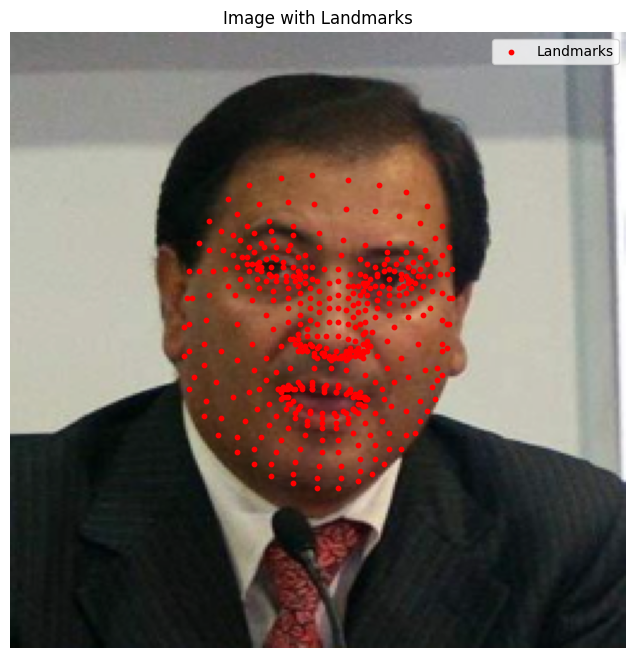

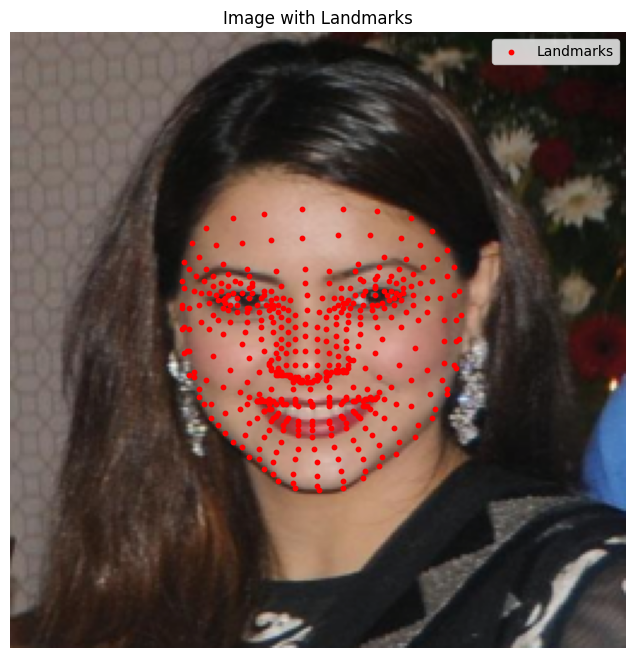

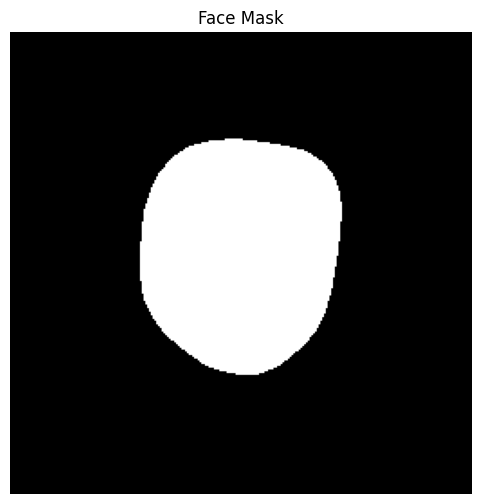

In [ ]:
# Fetch a batch from the dataloader and visualize landmarks for the first image in the batch
for source, target in dataloader:
    # Process source image
    source_image = source[0].permute(1, 2, 0).numpy()  # Convert tensor to numpy array
    source_image = (source_image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)  # Denormalize
    source_landmarks = get_landmark_locations((source_image * 255).astype(np.uint8))  # Detect landmarks

    # Process target image
    target_image = target[0].permute(1, 2, 0).numpy()  # Convert tensor to numpy array
    target_image = (target_image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)  # Denormalize
    target_landmarks = get_landmark_locations((target_image * 255).astype(np.uint8))  # Detect landmarks

    # Plot source image with landmarks
    plot_image_with_landmarks((source_image * 255).astype(np.uint8), source_landmarks)

    # Plot target image with landmarks
    plot_image_with_landmarks((target_image * 255).astype(np.uint8), target_landmarks)

    # Align source image to target landmarks
    aligned_image, transformed_landmarks = align_face_and_landmarks(
        (source_image * 255).astype(np.uint8), source_landmarks, target_landmarks
    )

    # Generate mask
    mask = generate_face_mask_from_mediapipe(source_image, source_landmarks)

    # Plot the mask
    plt.figure(figsize=(6, 6))
    plt.imshow(mask, cmap="gray")
    plt.title("Face Mask")
    plt.axis("off")
    plt.show()

    break

In [ ]:
# Initialize the network
model = MultiScaleTransformationNetwork()

# Load the pre-trained weights
'''checkpoint_path = "/content/drive/My Drive/aml/cnn_network_big_3.pth"
model.load_state_dict(torch.load(checkpoint_path))
print(f"Loaded pre-trained model from {checkpoint_path}")
model.to("cuda")'''

# Initialize the VGG feature extractor
vgg_extractor = VGGFeatures(layer_ids=[4, 9, 16, 23])

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)  # Reduce LR by half every 50 epochs

# Train the model and collect loss history
loss_history = train_transformation_network_with_alignment(  # Updated training loop function
    model=model,
    dataloader=dataloader,
    vgg_extractor=vgg_extractor,
    optimizer=optimizer,
    num_epochs=500,
    device="cuda"
)

# Plot the content loss individually
plt.figure(figsize=(10, 6))
plt.plot(loss_history["content_loss"], label="Content Loss", color='b')
plt.title("Content Loss During Training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Save the model checkpoint
checkpoint_path = "/content/drive/My Drive/aml/cnn_sourcetarget_4.pth"
torch.save(model.state_dict(), checkpoint_path)
print(f"Model saved to {checkpoint_path}")

Epoch [1/500], Batch [1/5]: Content Loss: 41.1226, Style Loss: 0.0034, Light Loss: 0.1746, TV Loss: 0.0732
Epoch [1/500] Summary: Content: 40.9317, Style: 0.0046, Light: 0.1401, TV: 0.0652, Total Loss: 41.1415
Epoch [2/500], Batch [1/5]: Content Loss: 40.4511, Style Loss: 0.0031, Light Loss: 0.1208, TV Loss: 0.0633
Epoch [2/500] Summary: Content: 39.5139, Style: 0.0030, Light: 0.1260, TV: 0.0604, Total Loss: 39.7033
Epoch [3/500], Batch [1/5]: Content Loss: 38.9047, Style Loss: 0.0031, Light Loss: 0.1281, TV Loss: 0.0651
Epoch [3/500] Summary: Content: 38.6530, Style: 0.0034, Light: 0.1283, TV: 0.0570, Total Loss: 38.8417
Epoch [4/500], Batch [1/5]: Content Loss: 37.1451, Style Loss: 0.0038, Light Loss: 0.1320, TV Loss: 0.0552
Epoch [4/500] Summary: Content: 37.7208, Style: 0.0032, Light: 0.1285, TV: 0.0518, Total Loss: 37.9043
Epoch [5/500], Batch [1/5]: Content Loss: 37.7370, Style Loss: 0.0028, Light Loss: 0.1410, TV Loss: 0.0452
Epoch [5/500] Summary: Content: 36.5967, Style: 0.003

TypeError: len() of unsized object

# Testing Function

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
from torchvision import transforms

def test_model_with_target(model, source_image_path, target_image_path, device="cuda"):
    """
    Tests the trained transformation network on a source and target image,
    aligning and processing them exactly as in training.

    Parameters:
        model (nn.Module): Trained transformation network.
        source_image_path (str): Path to the source image.
        target_image_path (str): Path to the target image.
        device (str): Device to use ('cuda' or 'cpu').

    Returns:
        None: Displays the transformed image.
    """
    model.eval()  # Set model to evaluation mode
    model.to(device)

    # Load images
    source_image = cv2.imread(source_image_path)
    target_image = cv2.imread(target_image_path)

    # Convert to RGB
    source_image = cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB)
    target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB)

    # Get landmarks for alignment
    source_landmarks = get_landmark_locations(source_image)
    target_landmarks = get_landmark_locations(target_image)

    if source_landmarks is None or target_landmarks is None:
        print("Failed to detect landmarks in one of the images.")
        return

    # Align source image to target landmarks
    aligned_source_image, _ = align_face_and_landmarks(source_image, source_landmarks, target_landmarks)

    # Generate mask from target landmarks
    mask = generate_face_mask_from_mediapipe(target_image, target_landmarks)

    # Apply training-like preprocessing
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    aligned_source_tensor = transform(aligned_source_image).unsqueeze(0).to(device)
    target_tensor = transform(target_image).unsqueeze(0).to(device)

    # Forward pass through the model
    with torch.no_grad():
        transformed_tensor = model(aligned_source_tensor)

    # Denormalize the transformed image
    transformed_tensor = transformed_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
    transformed_image = (transformed_tensor * 0.229 + 0.485).clip(0, 1) * 255
    transformed_image = transformed_image.astype(np.uint8)

    seamless_binary = True

    if seamless_binary:
      # Use seamless cloning for blending
      center = (target_image.shape[1] // 2, target_image.shape[0] // 2)  # Center for seamlessClone
      blended_image = cv2.seamlessClone(
          transformed_image, target_image, (mask * 255).astype(np.uint8), center, cv2.NORMAL_CLONE
      )
    else:
        blended_image = transformed_image

    # Visualize results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(aligned_source_image)
    plt.title("Aligned Source Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(target_image)
    plt.title("Target Image")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(blended_image)
    plt.title("Blended Image (Seamless Cloning)")
    plt.axis("off")

    plt.show()

# New Testing

True
True


<ipython-input-25-e255f8eef856>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/My Drive/aml/cnn_sourcetarget_4_epoch_205.

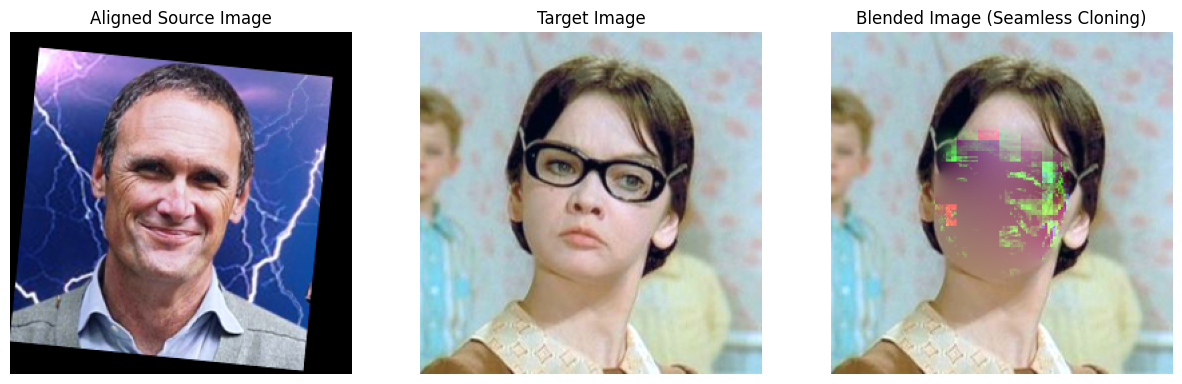

In [ ]:
# Dynamically fetch source and target images from the dataset
for source_images, target_images in dataloader:
    # Convert tensors to numpy arrays for visualization
    source_image = source_images[0].permute(1, 2, 0).cpu().numpy()  # (H, W, C)
    target_image = target_images[0].permute(1, 2, 0).cpu().numpy()  # (H, W, C)

    # Denormalize the images (reverse normalization)
    source_image = (source_image * 0.229 + 0.485).clip(0, 1)
    target_image = (target_image * 0.229 + 0.485).clip(0, 1)

    # Save them temporarily for testing
    from PIL import Image
    source_image_path = "/content/source_converted.png"
    target_image_path = "/content/target_converted.png"
    Image.fromarray((source_image * 255).astype(np.uint8)).save(source_image_path)
    Image.fromarray((target_image * 255).astype(np.uint8)).save(target_image_path)

    break  # Stop after fetching the first pair

# Check if the files exist
import os
print(os.path.exists(source_image_path))  # Should print True if the image exists
print(os.path.exists(target_image_path))  # Should print True if the image exists

# Load the trained model
model = MultiScaleTransformationNetwork()
model.load_state_dict(torch.load("/content/drive/My Drive/aml/cnn_sourcetarget_4_epoch_205.pth"))
model.to("cuda")

# Test the model
test_model_with_target(model, source_image_path, target_image_path)

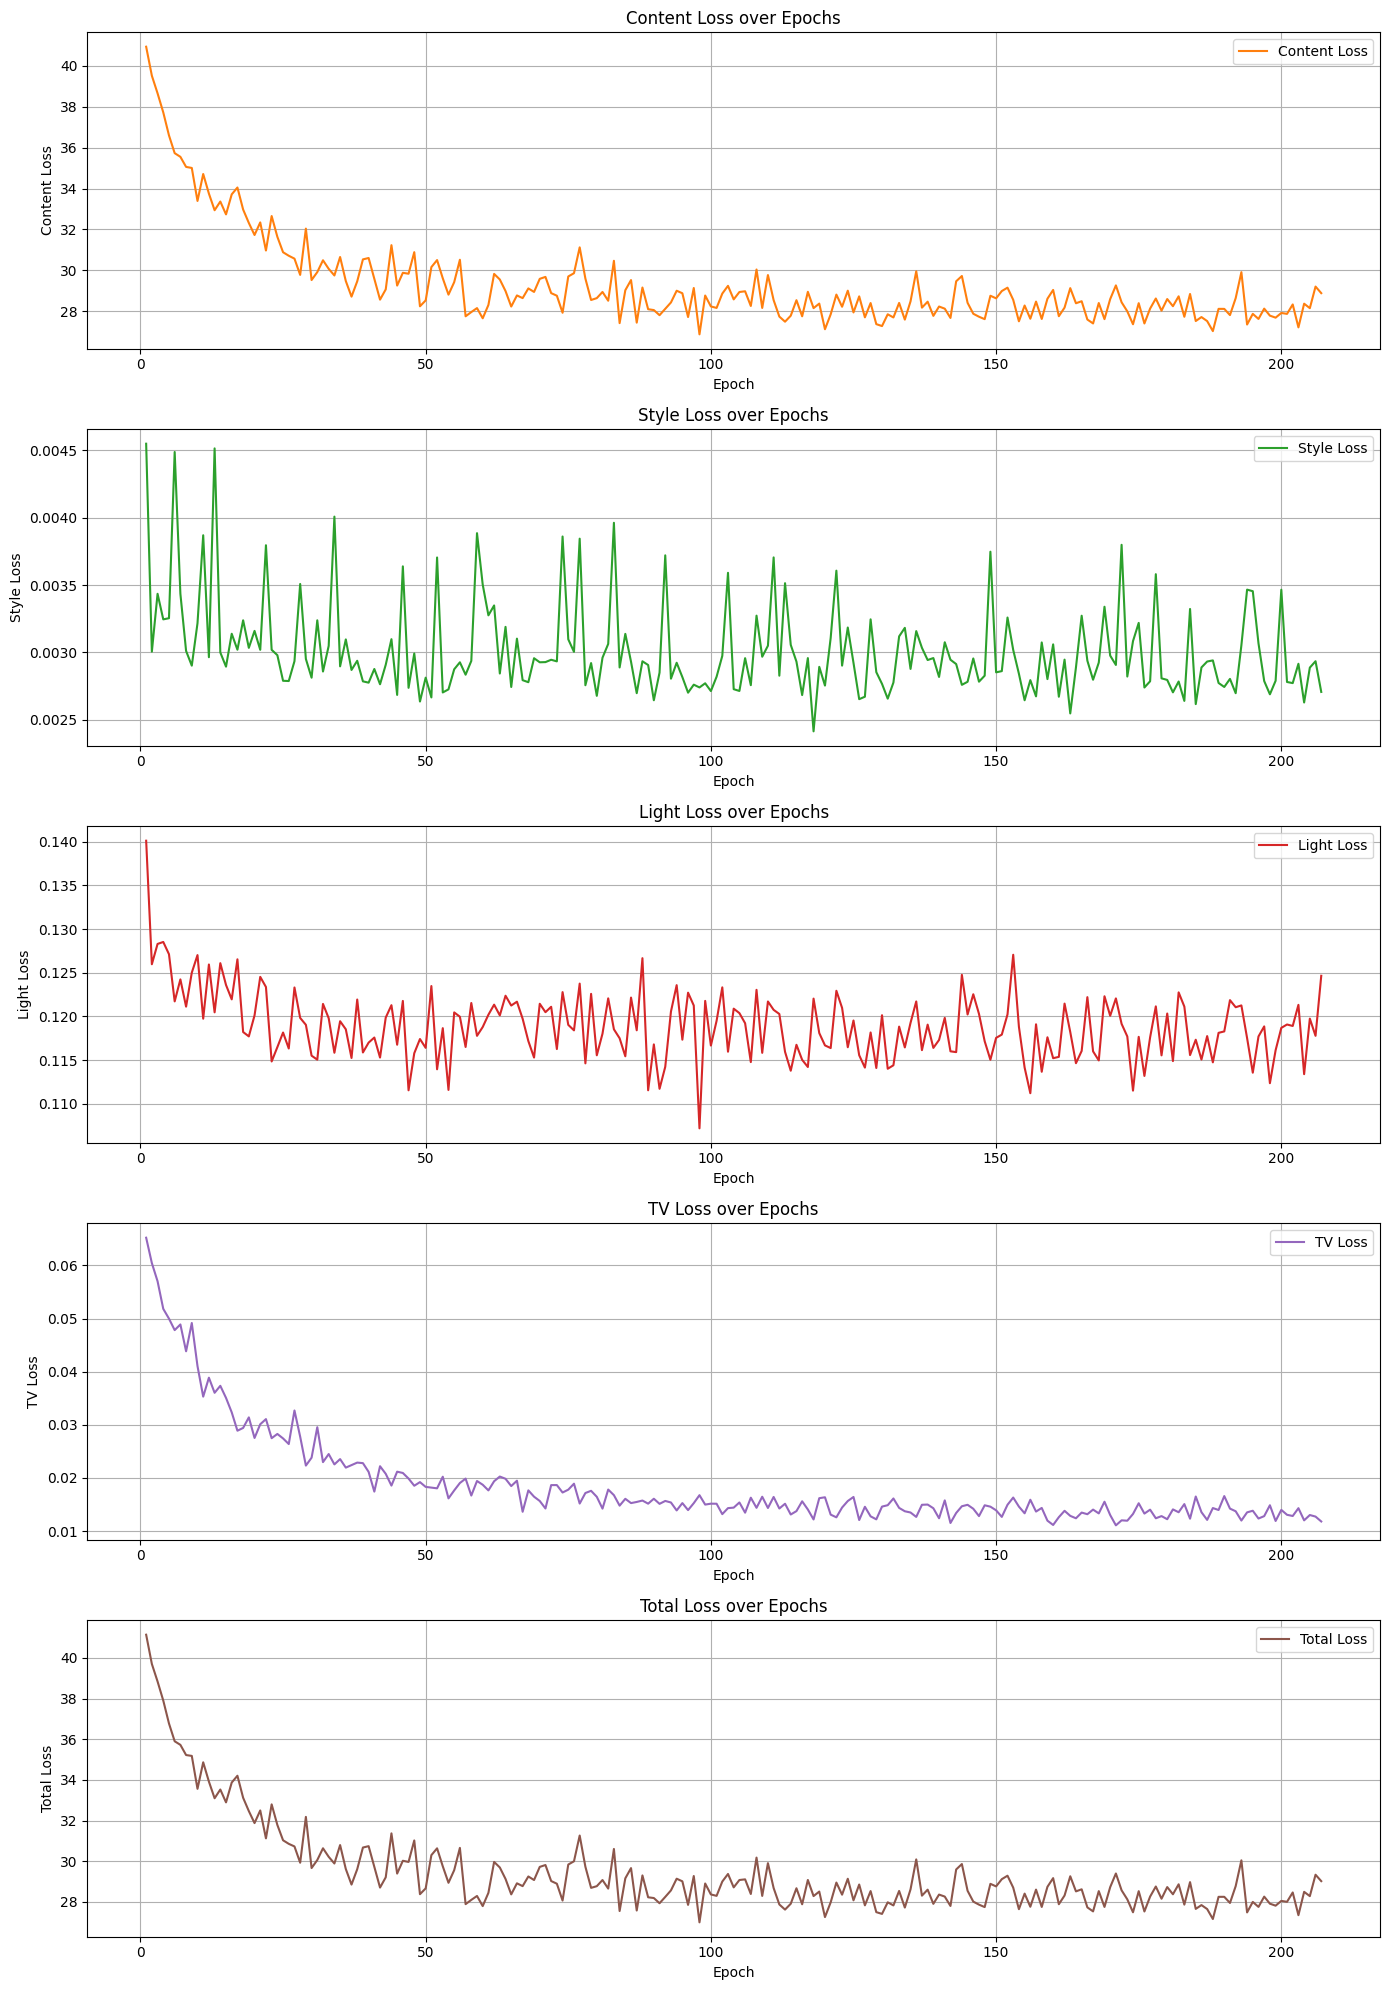

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = "/content/drive/My Drive/aml/training_losses_4.csv"
df = pd.read_csv(file_path, sep=",")

# Define the losses to plot
losses = ["Content Loss", "Style Loss", "Light Loss", "TV Loss", "Total Loss"]

# Set up the subplots
plt.figure(figsize=(14, 20))
for i, loss in enumerate(losses, 1):
    plt.subplot(len(losses), 1, i)
    plt.plot(df["Epoch"], df[loss], label=loss, color=f'C{i}')
    plt.title(f"{loss} over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel(loss)
    plt.grid(True)
    plt.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()
